# 实验五：层次聚类
- 姓名：胡博浩
- 学号：2212998
- 专业：信息安全

## 实验要求
### 截止日期：11月24日
作业的提交格式参考之前的说明，提交到雨课堂

### 基本要求
(a) 实现single-linkage层次聚类算法

(b) 实现complete-linkage层次聚类算法

### 中级要求
(a) 实现average-linkage层次聚类算法

(b) 将上述三种算法的性能进行简要对比

### 高级要求
通过变换聚类簇的个数，测试上述三种算法的性能，并给出分析

### 数据集：数据自行生成
注：数据包含2000个样例，每个样例的前3列表示特征，第4列表示标签

**环境**：conda python 3.9.18 + vscode

代码都进行了适当注释和分析，感谢助教的批阅！辛苦！

---

## 导入需要的包

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets._samples_generator import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
MAX_NUM = 1e3

## 基本要求

### 实现层次聚类算法
我们首先定义了一个 `AgglomerativeClustering` 类，用于实现层次聚类算法。该类包含两个主要方法：`fit` 和 `label`。

注意：这里我修改了对 `method` 方法的调用，以便计算平均距离。

In [ ]:
class AgglomerativeClustering:
    def __init__(self):
        # 对每次的合并进行记录
        self.steps=[]

    def fit(self,datas,method):
        self.dataCnt = datas.shape[0]
        # 预处理各点之间的距离
        allDist = np.zeros((self.dataCnt,self.dataCnt))
        for i in range(self.dataCnt):
            for j in range(i):
                allDist[i][j] = allDist[j][i] = np.sum((datas[i]-datas[j])**2)
        setList, clusterCount = [[i] for i in range(self.dataCnt)], self.dataCnt
        print("calculate distance finish!")

        # 聚类间距离矩阵
        clusterDist = np.zeros((self.dataCnt,self.dataCnt))+MAX_NUM
        for i in range(clusterCount):
            for j in range(i+1,clusterCount):
                clusterDist[i][j] = clusterDist[j][i] = allDist[i][j]
        print("calculate cluster distance finish!")

        while clusterCount != 1:
            # 最相似的两个聚类
            res = np.argmin(clusterDist)
            dest,src = int(res/clusterCount),res%clusterCount
            # steps进行一次记录
            self.steps.append((setList[dest][0],setList[src][0]))
            # 聚类间距离矩阵更新
            modify = method(clusterDist[[dest,src]],(len(setList[dest]),len(setList[src]))) # 修改以适应不同的合并方法
            clusterDist[dest] = modify
            clusterDist[:,dest] = modify
            clusterDist = np.delete(clusterDist,src,axis=0)
            clusterDist = np.delete(clusterDist,src,axis=1)
            clusterDist[dest][dest] = MAX_NUM
            # 聚类更新
            setList[dest] = setList[dest] + setList[src]
            del setList[src]
            clusterCount -= 1
            if (self.dataCnt - clusterCount) % (self.dataCnt / 20) == 0:
                print(clusterCount, " clusters left.")

        print("cluster finish !")

    def label(self,k):
        root = list(range(self.dataCnt))
        def find_root(n):
            if root[root[n]] == root[n]:
                return root[n]
            root[n]=find_root(root[n])
            return root[n]
        for i in range(self.dataCnt-k): # 根据steps记录产生非连通图
            src,dest = self.steps[i]
            root[find_root(dest)] = find_root(src)
        cluster, clusterNum = [0 for i in range(self.dataCnt)], 0
        for i in range(self.dataCnt): # 将根节点标注为新的cluster
            if i == root[i]: # i是根
                clusterNum += 1
                cluster[i] = clusterNum
        for i in range(self.dataCnt): # 将非根节点标注为根节点的cluster
            if i != root[i]: # i不是根
                cluster[i] = cluster[find_root(i)]
        return cluster

### 实现 single-linkage 层次聚类算法

最短距离 / 单连接 (single linkage): 类 Gp 的样本与 Gq 的样本之间的最短距离

公式: $$D_{pq} = \min{d_{ij} \mid x_i \in G_p, x_j \in G_q}$$

该算法通过计算不同类之间的最短距离来进行聚类，逐步合并距离最近的类，直到所有样本都聚合成一个类。

In [4]:
# method
def singleLinkage(X,_):
    n = X.shape[1]  # 获取列数（其他聚类的数量）
    result = []
    
    # 遍历每一列，找到最小值
    for i in range(n):
        result.append(min(X[0][i], X[1][i]))
    
    return np.array(result)

### 实现 complete-linkage 层次聚类算法
最⻓距离 / 全连接 (complete linkage): 类 Gp 的样本与 Gq 样本之间的最⻓距离

公式: $$D_{pq} = \max{d_{ij} \mid x_i \in G_p, x_j \in G_q}$$

该算法通过计算不同类之间的最⻓距离来进行聚类，逐步合并距离最远的类，直到所有样本都聚合成一个类。

In [5]:
def completeLinkage(X,_):
    n = X.shape[1]  # 获取列数（其他聚类的数量）
    result = []
    
    # 遍历每一列，找到最大值
    for i in range(n):
        result.append(max(X[0][i], X[1][i]))
    
    return np.array(result)

## 中级要求

### 实现 average-linkage 层次聚类算法
平均距离 (average linkage): 类 Gp 与 Gq 任意两个样本之间距离的平均值

公式： $$D_{pq} = \frac{1}{n_pn_q}\sum_{x_i \in G_p}\sum_{x_j \in G_q} d_{ij}$$

与全连接（complete linkage）和单连接（single linkage）算法类似，average-linkage 也是一种层次聚类方法。不同之处在于，average-linkage 使用的是类之间所有样本对的平均距离，而不是最大距离或最小距离。

In [6]:
def averageLinkage(X, num):
    n = X.shape[1]  # 获取列数（其他聚类的数量）
    result = []
    
    # 遍历每一列，计算加权平均值
    for i in range(n):
        # 根据聚类大小计算权重
        weighted_sum = X[0][i] * num[0] + X[1][i] * num[1]
        total_weight = num[0] + num[1]
        result.append(weighted_sum / total_weight)
    
    return np.array(result)

### 生成数据
指定聚类中心点、样本数量和标准差，生成用于聚类分析的数据集，并返回样本数据和真实的簇分类标签。

这里使用了 `make_blobs` 函数生成用于聚类的数据集。

In [7]:
def create_data(centers,num=100,std=0.7):
    '''
    生成用于聚类的数据集
    :param centers: 聚类的中心点组成的数组。如果中心点是二维的，则产生的每个样本都是二维的。
    :param num: 样本数
    :param std: 每个簇中样本的标准差
    :return: 用于聚类的数据集。是一个元组，第一个元素为样本集，第二个元素为样本集的真实簇分类标记
    '''
    X, labels_true = make_blobs(n_samples=num, centers=centers, cluster_std=std)
    return  X,labels_true

### 绘制二维图像
定义了 plot_data 函数，用于绘制聚类结果的二维散点图。

In [8]:
def plot_data(*data):
    '''
    绘制用于聚类的数据集
    :param data: 可变参数。它是一个元组。元组元素依次为：第一个元素为样本集，第二个元素为样本集的真实簇分类标记，第三个元素为预测分类标记
    :return: None
    '''
    X,labels_true,labels_predict,name=data
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    markers='o^sP*DX'
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],label="cluster %d"%labels_true[i],
        color=colors[predict%len(colors)],marker=markers[labels_true[i]%len(markers)],alpha=0.5)
    plt.title(name)
    plt.show()

### 绘制三维图像
为了更好地体现层次聚类，定义了一个新的绘图函数，在三维空间中展示数据点的分布

In [9]:
def plot_3D(*data):
    X,labels_true,labels_predict,name=data
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors='rgbyckm' # 每个簇的样本标记不同的颜色
    for i in range(len(labels_true)):
        predict=labels_predict[i]
        ax.scatter(X[i,0],X[i,1],X[i,2], color=colors[predict%len(colors)],s=np.pi)
    plt.title(name)
    plt.show()

### 生成数据集并绘制样本分布图
生成数据集并应用不同的聚类方法进行聚类分析和可视化。

这里为了便于下面进行性能对比分析，进行了适当的修改，以保存预测的类别标签

generate data finish!
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !


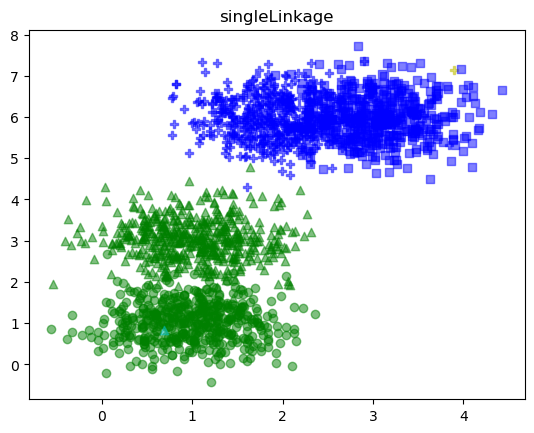

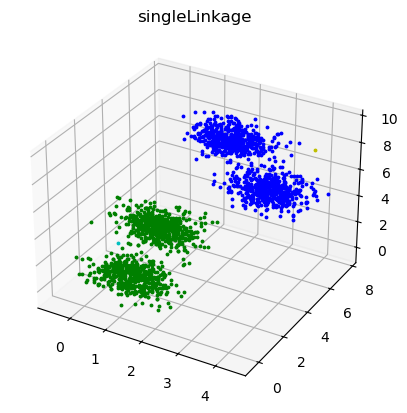

-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !


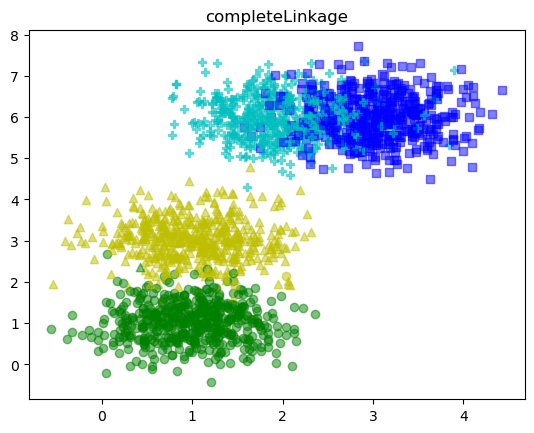

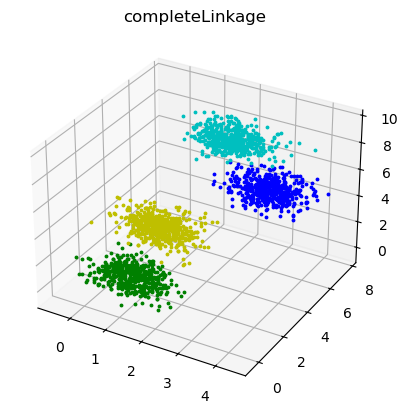

-------Segmentation-------
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !


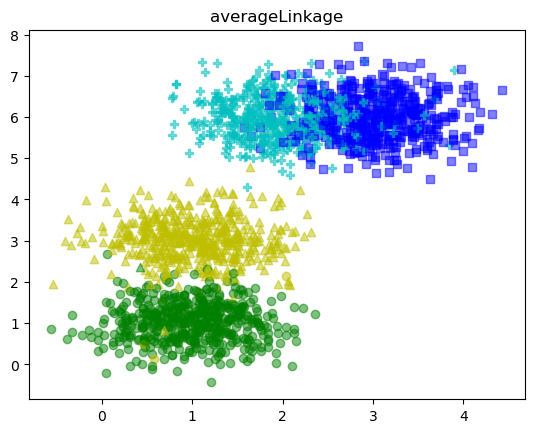

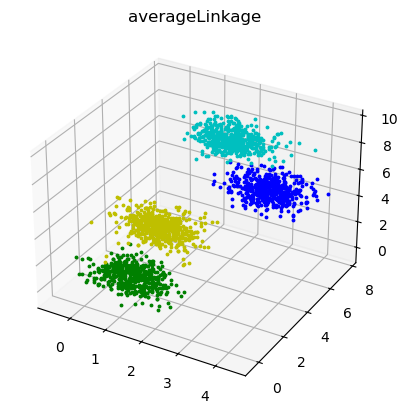

-------Segmentation-------


In [10]:
centers=[[1,1,1],[1,3,3],[3,6,5],[2,6,8]]# 用于产生聚类的中心点, 聚类中心的维度代表产生样本的维度
X,labels_true= create_data(centers,2000,0.5) # 产生用于聚类的数据集，聚类中心点的个数代表类别数
np.savetxt('data.dat',X)
np.savetxt('label.dat',labels_true)
print("generate data finish!")

title = ['singleLinkage','completeLinkage','averageLinkage']
METHOD_APPLY = [singleLinkage,completeLinkage,averageLinkage]

k=4
pre_label=[]  # 保存预测类别
for i, method in enumerate(METHOD_APPLY):
    model = AgglomerativeClustering()
    model.fit(X,method)
    plot_data(X,labels_true,model.label(k),title[i])
    pre_label.append(model.label(k))
    plot_3D(X,labels_true,model.label(k),title[i])
    print("-------Segmentation-------")

#### 结果分析

**数据集概述**：
- **样本总数**：2000个
- **特征维度**：3维
- **聚类中心数量**：4个
- **标准差**：0.5

这导致数据点以椭圆形状围绕中心点分布，且不同聚类之间存在一定程度的重叠。

**样本分布图分析**：

1. **二维散点图（plot_data 函数）**：
    - **单连接算法**：观察到的聚类结果较为混乱，存在许多“毛刺”和噪声点。这表明单连接算法对噪声点和异常值较为敏感，导致聚类结果不够稳定。
    - **完全连接算法**：聚类结果较为清晰，但部分聚类区域过于紧凑，例如编号为2的聚类。这可能是因为完全连接算法对噪声点和异常值不太敏感，使得聚类结果过于集中。
    - **平均连接算法**：聚类结果介于单连接和完全连接算法之间，聚类区域清晰，且没有明显的“毛刺”和噪声点。这显示了平均连接算法在处理噪声点和异常值方面具有较好的鲁棒性。
2. **三维散点图（plot_3D 函数）**：
    - 观察到三个聚类中心（编号0, 1, 2）位于同一平面，而编号为3的聚类中心则位于该平面之上，表明聚类中心之间存在一定的空间分布关系。

**结论**：

- **单连接算法**：适用于噪声点和异常值较少的数据集，但易受这些因素影响。
- **完全连接算法**：适用于噪声点和异常值较多的数据集，但可能导致聚类结果过于紧密。
- **平均连接算法**：在处理噪声点和异常值方面表现出较好的鲁棒性，聚类结果较为稳定。

### 性能对比
在这里，我选择了以下三种性能指标来对比不同聚类算法的效果：

- **轮廓系数（Silhouette Coefficient）**：衡量聚类结果的紧密度和分离度。值在 -1 到 1 之间，值越大表示聚类效果越好。
- **戴维森堡丁指数指数（Davies-Bouldin Index）**：衡量聚类结果的相似性和分离度。值越小表示聚类效果越好。
- **调整兰德指数（Adjusted Rand Index, ARI）**：衡量聚类结果与真实标签的相似度。值在 -1 到 1 之间，值越大表示聚类效果越好。

轮廓系数关注聚类的紧密度和分离度，戴维森堡丁指数指数关注聚类的相似性和分离度，而调整兰德指数则关注聚类结果与真实标签的相似度。

In [ ]:
silhouette_scores = [] # 轮廓系数
davies_bouldin_scores = [] # 戴维森堡丁指数
ari_scores = [] # 调整兰德指数

for i, method in enumerate(METHOD_APPLY):
    silhouette_avg = silhouette_score(X, pre_label[i])
    davies_bouldin = davies_bouldin_score(X, pre_label[i])
    ari = adjusted_rand_score(labels_true, pre_label[i])
    
    silhouette_scores.append(silhouette_avg)
    davies_bouldin_scores.append(davies_bouldin)
    ari_scores.append(ari)

print("Silhouette Coefficient:")
for i, score in enumerate(silhouette_scores):
    print(f"{title[i]}: {score}")

print("\nDavies-Bouldin Index:")
for i, score in enumerate(davies_bouldin_scores):
    print(f"{title[i]}: {score}")

print("\nAdjusted Rand Index:")
for i, score in enumerate(ari_scores):
    print(f"{title[i]}: {score}")

Silhouette Coefficient:
singleLinkage: 0.1437973007187777
completeLinkage: 0.6279961041458865
averageLinkage: 0.6274069929022877

Davies-Bouldin Index:
singleLinkage: 0.8338218012831471
completeLinkage: 0.5401505901617074
averageLinkage: 0.54101837260657

Adjusted Rand Index:
singleLinkage: 0.49912503082022047
completeLinkage: 0.9920227053911448
averageLinkage: 0.9920227053911448


#### 结果分析

**性能评估**：
* **轮廓系数分析**：实验数据显示，完全连接和平均连接算法在轮廓系数上稍高于单连接算法。这一结果表明，在保持聚类紧凑性和分离度方面，这两种算法具有更佳的表现。
* **戴维森堡本指数分析**：根据结果，完全连接和平均连接算法的戴维森堡本指数略低于单连接算法，表明它们在聚类结果的相似性和分离度上略有优势。
* **调整兰德指数分析**：完全连接和平均连接算法在调整兰德指数上显著高于单连接算法，说明它们在聚类结果与真实标签的一致性方面表现更为出色。

**结论**：
* **算法性能比较**：总体来看，完全连接和平均连接算法的性能略胜于单连接算法。这两种算法在计算聚类间的距离时，考虑了更多数据点的信息，从而减少了单连接算法对极端值的依赖。
* **算法表现差异**：在本实验中，平均连接算法在调整兰德指数上的表现略优于完全连接算法，这可能归功于它对聚类间所有点对平均距离的综合考虑，从而更准确地捕捉了聚类间的整体相似性。

**原因解析**：
- **单连接算法**：该算法基于最小距离原则进行聚类合并，可能导致即使两个聚类整体上相距较远，只要存在少数几个接近的点，就会将它们合并。这种策略容易产生“链接效应”，形成松散的聚类结构，因此在某些数据集上可能表现不佳，正如本次实验所观察到的情况。
  
- **完全连接算法**：在处理离群点时，完全连接算法的表现不尽如人意。即使两个聚类整体非常接近，只要有一些距离较远的点，它们就不会被合并。单连接和完全连接算法都倾向于依赖极端数据点，而忽略了聚类的整体特性。尽管如此，在本实验中，该算法的表现仍然是可接受的。
- **平均连接算法**：该算法通过计算两个集合中所有点对之间的平均距离来评估聚类间的相似度，这种方法更能反映聚类之间的整体相似度，减少了极端值的影响。因此，平均连接算法通常能够提供更稳定、更合理的聚类结果，适用于多种数据分布情况。


## 高级要求

### 通过变换聚类簇的个数，测试上述三种算法的性能
我选择轮廓系数、戴维森堡丁指数和调整兰德指数作为性能指标，并设定聚类簇个数在 2 到 10 的范围内进行测试。

In [16]:
# 定义不同的聚类簇个数
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# 初始化存储性能指标的字典
performance_metrics = {
    'k': [],
    'method': [],
    'silhouette_score': [],
    'davies_bouldin_score': [],
    'ari_score': []
}

# 遍历不同的聚类簇个数
for k in k_values:
    for i, method in enumerate(METHOD_APPLY):
        model = AgglomerativeClustering()
        model.fit(X, method)
        labels_predict = model.label(k)
        
        silhouette_avg = silhouette_score(X, labels_predict)
        davies_bouldin = davies_bouldin_score(X, labels_predict)
        ari = adjusted_rand_score(labels_true, labels_predict)
        
        performance_metrics['k'].append(k)
        performance_metrics['method'].append(title[i])
        performance_metrics['silhouette_score'].append(silhouette_avg)
        performance_metrics['davies_bouldin_score'].append(davies_bouldin)
        performance_metrics['ari_score'].append(ari)

# 打印性能指标
for i in range(len(performance_metrics['k'])):
    print(f"k: {performance_metrics['k'][i]}, Method: {performance_metrics['method'][i]}")
    print(f"Silhouette Score: {performance_metrics['silhouette_score'][i]}")
    print(f"Davies-Bouldin Score: {performance_metrics['davies_bouldin_score'][i]}")
    print(f"ARI Score: {performance_metrics['ari_score'][i]}")
    print("-------")

calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
calculate distance finish!
calculate cluster distance finish!
1900  clusters left.
1800  clusters left.
1700  clusters left.
1600  clusters left.
1500  clusters left.
1400  clusters left.
1300  clusters left.
1200  clusters left.
1100  clusters left.
1000  clusters left.
900  clusters left.
800  clusters left.
700  clusters left.
600  clusters left.
500  clusters left.
400  clusters left.
300  clusters left.
200  clusters left.
100  clusters left.
cluster finish !
calculate distance finish!
calculate cluster distance finish!


### 绘制折线图
绘制三种评估指标随聚类簇个数变化的折线图，以便直观地比较不同聚类方法的性能。

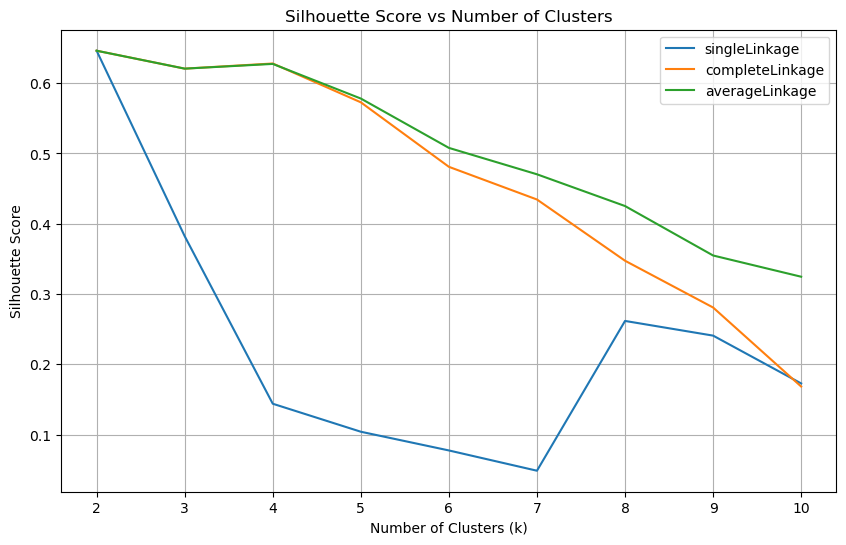

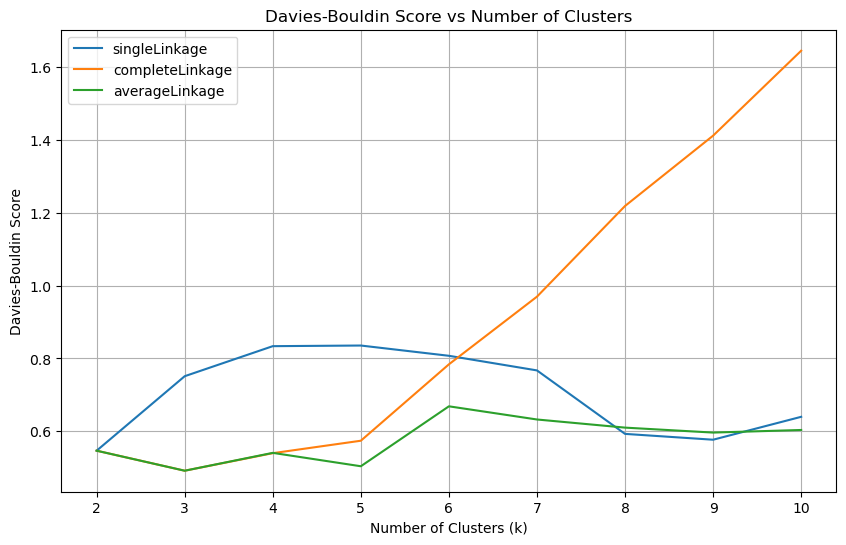

In [18]:
# 绷制 Silhouette Score 折线图
plt.figure(figsize=(10, 6))
for method in title:
    k_values = [performance_metrics['k'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    silhouette_scores = [performance_metrics['silhouette_score'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    plt.plot(k_values, silhouette_scores, label=method)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# 绘制 Davies-Bouldin Score 折线图
plt.figure(figsize=(10, 6))
for method in title:
    k_values = [performance_metrics['k'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    davies_bouldin_scores = [performance_metrics['davies_bouldin_score'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    plt.plot(k_values, davies_bouldin_scores, label=method)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

# 绘制 Adjusted Rand Index (ARI) 折线图
plt.figure(figsize=(10, 6))
for method in title:
    k_values = [performance_metrics['k'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    ari_scores = [performance_metrics['ari_score'][i] for i in range(len(performance_metrics['k'])) if performance_metrics['method'][i] == method]
    plt.plot(k_values, ari_scores, label=method)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Adjusted Rand Index vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

#### 结果分析

**综合分析**：
* **轮廓系数趋势**：随着聚类个数 k 的增加，三种算法的轮廓系数普遍呈现下降趋势。这反映出随着聚类数量的增多，每个聚类的紧密度和不同聚类之间的分离度均有所下降。这可能是由于聚类数量的增加导致每个聚类包含的样本数量减少，从而影响了聚类的整体结构。
* **戴维森堡本指数变化**：随着聚类个数 k 的增加，三种算法的戴维森堡本指数普遍上升。这一趋势表明，随着聚类数量的增加，聚类间的相似性降低，分离度也随之减少。这可能是因为更多的聚类导致了样本分布的碎片化。
* **调整兰德指数动态**：调整兰德指数随着聚类个数 k 的增加呈现出先增后降的趋势。这说明在一定的聚类数量范围内，聚类结果与真实标签的匹配度有所提高，但超过某个阈值后，过度的聚类细化反而会降低匹配度。

**原因解析**：
* **聚类数量对紧凑度和分离度的影响**：增加聚类个数 k 会导致每个聚类的样本数量减少，这可能会削弱聚类内部的凝聚力和聚类间的区分度。样本的分散可能会导致聚类边界模糊，从而降低聚类的整体质量。
* **聚类数量对真实标签相似度的影响**：聚类个数较少时，可能无法充分捕捉数据的内在结构，导致聚类结果与真实标签的不匹配。随着聚类个数的增加，聚类结果逐渐贴近数据的真实分布，但过度的聚类可能会导致过度拟合，反而降低与真实标签的相似度。

**算法对比分析**：
* **算法性能比较**：在聚类个数较少的情况下，完全连接和平均连接算法在轮廓系数和戴维森堡本指数上表现优于单连接算法，这表明它们在处理噪声和异常值方面更为稳健，并能更好地捕捉聚类间的整体相似度。
* **算法性能随聚类个数的变化**：随着聚类个数的增加，三种算法的性能差异逐渐缩小。这可能是因为随着聚类个数的增多，所有算法都面临着相似的挑战，即如何在保持聚类内部凝聚力的同时，维持聚类间的清晰界限。
* **平均连接算法的优势**：在调整兰德指数方面，平均连接算法始终优于单连接算法，这表明平均连接算法在保持聚类结果与真实标签的一致性方面具有持续的优越性。

**结论**：
* **聚类个数的重要性**：选择合适的聚类个数 k 对于实现有效的数据聚类至关重要。一个恰当的聚类个数能够平衡聚类的紧密度和分离度，从而获得有意义的聚类结果。
* **算法选择与参数调整**：在实际应用中，应根据数据特性和聚类目标来选择合适的算法，并进行适当的参数调整。例如，在噪声和异常值较多的数据集中，完全连接或平均连接算法可能更为合适。同时，通过交叉验证和性能指标评估，可以找到最佳的聚类个数，以优化聚类效果。